# Classification Predict

## Table of Contents


1. [Introduction](#1.-Introduction)
    - Problem statement
    - Objective
    
2. [Importing Packages](#2.-Importing-Packages)

3. [Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
    - Load Data 
    
4. [Pre-processing](#4.-Pre-processing)
    - [Removing the Noise](#Removing-the-Noise)
       - [Lowercasing Data](#Lowercasing-Data) 
       - [Removing Contractions](#Removing-Contractions)
       - [Removing Web Urls](#Removing-Web-Urls)
       - [Removing Punctuations](#Removing-Punctuations)
       - [Removing Numbers](#Removing-Numbers)
       - [Removing Extra Space](#Removing-Extra-Space) 
       - [Tokenization](#Tokenization)
       - [Removing Stop Words](#Removing-Stop-Words)
       - [Removing Emojis](#Removing-Emojis)
       - [Removing Punctuation once more](#Removing-Punctuation-once-more)
       - [Tokenization_2](#Tokenization_2)
       - [Stemmer](#Stemmer)
       - [Lemmatization](#Lemmatization)
      
       
    
5. [Feature Engineering](#5.-Feature-Engineering)
    - Bag of Words
    - N-grams
        
6. [Modelling](#6.-Modelling)
7. [Conclusion](#7.-Conclusion)

## 1. Introduction
[Back to Table of Contents](#Table-of-Contents)

###  Problem Statement

Many companies would like to determine how their customers perceive climate change and whether or not they believe it is a real threat. 
Knowledge of this would add to their market research efforts in gauging how their product/service may be received.

An accurate and robust solution to this problem would give the companies access to a broad understanding of consumer sentiment, spanning multiple demographic and geographics, as a result increasing companies' insights and informing future
marketing strategies for the betterment of consumer experience and company performance.



### Objective

Building a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data. The tweets belonging to any of the following class descriptions:

2 News: the tweet links to factual news about climate change

1 Pro: the tweet supports the belief of man-made climate change

0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change

-1 Anti: the tweet does not believe in man-made climate change Variable definitions

## 2. Importing Packages
[Back to Table of Contents](#Table-of-Contents)

In [3]:
import nltk
import string
import re
import string
import contractions
import sys  
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from cleantext import clean

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud , STOPWORDS
# from pandas.core.common import SettingWithCopyWarning
from comet_ml import Experiment

### Starting comet experiment

In [4]:
experiment = Experiment(api_key="DgOUdi281ImcebtckQoquGSnl",project_name="general",workspace="bronwyn",)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/bronwyn/general/ad3eb55390c14f96b7158e0c272f7887



## 3. Exploratory Data Analysis
[Back to Table of Contents](#Table-of-Contents)

### Load data

In [5]:
# Display data
data = pd.read_csv("train.csv")
data.head(3)

sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562

In [6]:
# loading train data
train_data = pd.read_csv("train.csv")

In [7]:
#see the min, max and mode(from dictionary) category of the sentiments
data_sorted = data[["message", "sentiment"]]

dict_ = {}

for i in data_sorted["sentiment"]:
    if i in dict_:
        dict_[i] += 1
    else:
        dict_[i] = 1

print("total number of sentiments:", len(data_sorted))
print("counts of the respective sentiments:", dict_)

total number of sentiments: 15819
counts of the respective sentiments: {1: 8530, 2: 3640, 0: 2353, -1: 1296}


In [8]:
#the skewness and kurtosis(lack of ourtliers) of the sentiments
print("skewness: ", data_sorted["sentiment"].skew())
print("kurtosis: ",data_sorted["sentiment"].kurtosis())

skewness:  -0.6839586535115556
kurtosis:  0.12297618882173778


Text(0.5, 1.0, 'Distribution of Sentiments')

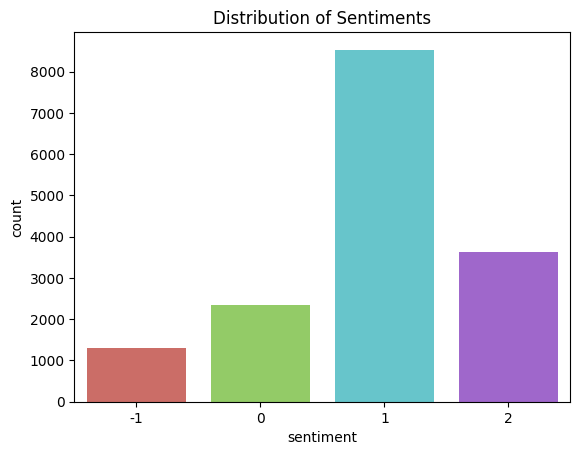

In [9]:
#the frequency distribution of the sentiments
#Thibello
sns.countplot(x = 'sentiment', data = data_sorted, palette="hls")
plt.title("Distribution of Sentiments")

In [10]:
#counting the number of respective impurities

punctuations = 0
numbers = 0

for i in data_sorted["message"]:
    for k in i.split():
        if k in string.punctuation:
            punctuations+=1
        if k.isdigit():
            numbers += 1
print("punctuations present in the tweets:", punctuations)
print("numbers present in the tweets:", numbers)


punctuations present in the tweets: 1440
numbers present in the tweets: 1111


## 4. Pre-processing
[Back to Table of Contents](#Table-of-Contents)

### Revise data 

In [11]:
#making the tweetid the index
data = pd.read_csv("train.csv", index_col = "tweetid")
data.head(3)


sentiment                                            message
tweetid                                                              
625221           1  PolySciMajor EPA chief doesn't think carbon di...
126103           1  It's not like we lack evidence of anthropogeni...
698562           2  RT @RawStory: Researchers say we have three ye...

In [12]:
#rearrange the columns for clarity
data_sorted = data[["message", "sentiment"]]
data_sorted.head(3)

message  sentiment
tweetid                                                              
625221   PolySciMajor EPA chief doesn't think carbon di...          1
126103   It's not like we lack evidence of anthropogeni...          1
698562   RT @RawStory: Researchers say we have three ye...          2

## Removing the Noise

### Lowercasing Data

In [13]:
#make everything lower case
'''
Converting every letter into lowercase helps to understand better what the words 
state.
'''
data_sorted['message'] = data_sorted['message'].str.lower()
data_sorted.head(20)

message  sentiment
tweetid                                                              
625221   polyscimajor epa chief doesn't think carbon di...          1
126103   it's not like we lack evidence of anthropogeni...          1
698562   rt @rawstory: researchers say we have three ye...          2
573736   #todayinmaker# wired : 2016 was a pivotal year...          1
466954   rt @soynoviodetodas: it's 2016, and a racist, ...          1
425577   worth a read whether you do or don't believe i...          1
294933   rt @thenation: mike pence doesn’t believe in g...          1
992717   rt @makeandmendlife: six big things we can all...          1
664510   @aceofspadeshq my 8yo nephew is inconsolable. ...          1
260471   rt @paigetweedy: no offense… but like… how do ...          1
295793   rt @stephenschlegel: she's thinking about how ...          1
763719   i do hope people who are vocal about climate c...          1
454673   rt @tveitdal: we only have a 5 percent chance ...          2
41161    rt @alifaith55: oh. my. god.\n\ntrump's govern...          1
658092   fossil fuel giant exxonmobil ‘misled’ the publ...          2
319524   rt @glblctzn: 'i don't wanna live forever – an...          1
698009   rt @jackholmes0: issues scrubbed from https://...          1
490604   rt @patagonia: if our elected leaders fail to ...          1
228658   rt @sensanders: we have a president-elect who ...          1
547924   calum: *tweets abt reunitingish w the cast*\n-...          0

In [14]:
data_sorted.tail(20)

message  sentiment
tweetid                                                              
52528    rt @sethmacfarlane: hrc proposes installing ha...          1
580806   rt @sapinker: the only practical way to avert ...          1
331127   rt @sensanders: on virtually every major issue...          1
585908   michael bloomberg to world leaders: ignore tru...          2
296403   suicides of nearly 60,000 indian farmers linke...          2
386076   rt @cathdweeb: me with full knowledge of globa...          1
830383   rt @grindtv: new head of epa says climate chan...          2
213863   rt @herbermp: @sness5561_ness al gore is a idi...         -1
447067   #scottpruit climate change comments would be l...          1
127777   rt @thepowersthatbe: now if she could only be ...          0
705048   the quest to capture and store carbon — and sl...          2
572819   this global warming so late in the season is p...          0
426353   rt @stephenschlegel: she's thinking about how ...          1
989478   rt @sierraclub: 2016: hottest year in history....          1
442853   rt @thinkprogress: epa head falsely claims car...          1
22001    rt @ezlusztig: they took down the material on ...          1
17856    rt @washingtonpost: how climate change could b...          2
384248   notiven: rt: nytimesworld :what does trump act...          0
819732   rt @sara8smiles: hey liberals the climate chan...         -1
806319   rt @chet_cannon: .@kurteichenwald's 'climate c...          0

### Removing Contractions

In [15]:
#expand all existing contractions

def expand_contractions(tweet):
    return " ".join([contractions.fix(c) for c in tweet.split()])

data_sorted["message"] = data_sorted["message"].apply(expand_contractions)
data_sorted.head()

NameError: name 'contractions' is not defined

### Removing Web Urls

In [16]:
#remove web urls 
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
data_sorted['message'] = data_sorted['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)
data_sorted.iloc[0]['message']

"polyscimajor epa chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? url-web via @mashable"

### Removing Punctuations

Removing punctuation marks assists us to treat every word equally, 
E.g sweet! and sweet are the same without punctuation. 

In [17]:
#remove all punctuations

def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

data_sorted['message'] = data_sorted['message'].apply(remove_punctuation)
data_sorted.head()

message  sentiment
tweetid                                                              
625221   polyscimajor epa chief doesnt think carbon dio...          1
126103   its not like we lack evidence of anthropogenic...          1
698562   rt rawstory researchers say we have three year...          2
573736   todayinmaker wired  2016 was a pivotal year in...          1
466954   rt soynoviodetodas its 2016 and a racist sexis...          1

In [18]:
data_sorted.iloc[0]['message']

'polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via mashable'

### Removing Numbers

"For example, when we are doing sentiment analysis then the number doesn’t hold any specific meaning to the data but if the task is to perform NER (Name Entity Recognition) or POS (Part of Speech tagging) then use the removing of number technique carefully."

In [19]:
def remove_digits(post):
    return ''.join([i for i in post if not i.isdigit()])

data_sorted['message'] = data_sorted['message'].apply(remove_digits)
data_sorted.head()

message  sentiment
tweetid                                                              
625221   polyscimajor epa chief doesnt think carbon dio...          1
126103   its not like we lack evidence of anthropogenic...          1
698562   rt rawstory researchers say we have three year...          2
573736   todayinmaker wired   was a pivotal year in the...          1
466954   rt soynoviodetodas its  and a racist sexist cl...          1

In [20]:
data_sorted.iloc[3]['message']

'todayinmaker wired   was a pivotal year in the war on climate change urlweb'

In [21]:
len(data_sorted.iloc[3]['message'])

75

### Removing Extra Space

Removing expace could help reduce the memory usage 

In [22]:
def remove_extra_space(text):
    return " ".join(text.split())

data_sorted['message'] = data_sorted['message'].apply(remove_extra_space)
data_sorted.head()

message  sentiment
tweetid                                                              
625221   polyscimajor epa chief doesnt think carbon dio...          1
126103   its not like we lack evidence of anthropogenic...          1
698562   rt rawstory researchers say we have three year...          2
573736   todayinmaker wired was a pivotal year in the w...          1
466954   rt soynoviodetodas its and a racist sexist cli...          1

In [23]:
data_sorted.iloc[3]['message']

'todayinmaker wired was a pivotal year in the war on climate change urlweb'

In [24]:
len(data_sorted.iloc[3]['message']) 

73

The decrease in the number of characters shows that extra space have been removed.

### Tokenization

In [25]:
#tokenisation to treat each word with respect
tokeniser = TreebankWordTokenizer()
data_sorted['message'] = data_sorted['message'].apply(tokeniser.tokenize)

data_sorted

message  sentiment
tweetid                                                              
625221   [polyscimajor, epa, chief, doesnt, think, carb...          1
126103   [its, not, like, we, lack, evidence, of, anthr...          1
698562   [rt, rawstory, researchers, say, we, have, thr...          2
573736   [todayinmaker, wired, was, a, pivotal, year, i...          1
466954   [rt, soynoviodetodas, its, and, a, racist, sex...          1
...                                                    ...        ...
22001    [rt, ezlusztig, they, took, down, the, materia...          1
17856    [rt, washingtonpost, how, climate, change, cou...          2
384248   [notiven, rt, nytimesworld, what, does, trump,...          0
819732   [rt, sarasmiles, hey, liberals, the, climate, ...         -1
806319   [rt, chetcannon, kurteichenwalds, climate, cha...          0

[15819 rows x 2 columns]

In [26]:
data_sorted.iloc[0]['message']

['polyscimajor',
 'epa',
 'chief',
 'doesnt',
 'think',
 'carbon',
 'dioxide',
 'is',
 'main',
 'cause',
 'of',
 'global',
 'warming',
 'and',
 'wait',
 'what',
 'urlweb',
 'via',
 'mashable']

### Removing Stop Words

In [27]:
#remove standard stop words, which are words of insignificance
def remove_stop_words(tokens):    
    return [t for t in tokens if t not in stopwords.words('english')]

data_sorted['message'] = data_sorted['message'].apply(remove_stop_words)
data_sorted

message  sentiment
tweetid                                                              
625221   [polyscimajor, epa, chief, doesnt, think, carb...          1
126103   [like, lack, evidence, anthropogenic, global, ...          1
698562   [rt, rawstory, researchers, say, three, years,...          2
573736   [todayinmaker, wired, pivotal, year, war, clim...          1
466954   [rt, soynoviodetodas, racist, sexist, climate,...          1
...                                                    ...        ...
22001    [rt, ezlusztig, took, material, global, warmin...          1
17856    [rt, washingtonpost, climate, change, could, b...          2
384248   [notiven, rt, nytimesworld, trump, actually, b...          0
819732   [rt, sarasmiles, hey, liberals, climate, chang...         -1
806319   [rt, chetcannon, kurteichenwalds, climate, cha...          0

[15819 rows x 2 columns]

In [28]:
for i in data_sorted["message"]:
    print(i)

['polyscimajor', 'epa', 'chief', 'doesnt', 'think', 'carbon', 'dioxide', 'main', 'cause', 'global', 'warming', 'wait', 'urlweb', 'via', 'mashable']
['like', 'lack', 'evidence', 'anthropogenic', 'global', 'warming']
['rt', 'rawstory', 'researchers', 'say', 'three', 'years', 'act', 'climate', 'change', 'it’s', 'late', 'urlweb', 'urlweb…']
['todayinmaker', 'wired', 'pivotal', 'year', 'war', 'climate', 'change', 'urlweb']
['rt', 'soynoviodetodas', 'racist', 'sexist', 'climate', 'change', 'denying', 'bigot', 'leading', 'polls', 'electionnight']
['worth', 'read', 'whether', 'dont', 'believe', 'climate', 'change', 'urlweb', 'urlweb']
['rt', 'thenation', 'mike', 'pence', 'doesn’t', 'believe', 'global', 'warming', 'smoking', 'causes', 'lung', 'cancer', 'urlweb']
['rt', 'makeandmendlife', 'six', 'big', 'things', 'today', 'fight', 'climate', 'change', 'climate', 'activistã¢â‚¬â¦', 'urlweb', 'hã¢â‚¬â¦']
['aceofspadeshq', 'yo', 'nephew', 'inconsolable', 'wants', 'die', 'old', 'age', 'like', 'perish

### Removing Emojis

In [29]:
from cleantext import clean

In [30]:
def remove_emoji(data): 
    for i in data:
        return clean(data, no_emoji=True)

data_sorted['message'] = data_sorted['message'].apply(remove_emoji)
data_sorted

TypeError: clean() got an unexpected keyword argument 'no_emoji'

In [31]:
for i in data_sorted["message"]:
    print(i)

['polyscimajor', 'epa', 'chief', 'doesnt', 'think', 'carbon', 'dioxide', 'main', 'cause', 'global', 'warming', 'wait', 'urlweb', 'via', 'mashable']
['like', 'lack', 'evidence', 'anthropogenic', 'global', 'warming']
['rt', 'rawstory', 'researchers', 'say', 'three', 'years', 'act', 'climate', 'change', 'it’s', 'late', 'urlweb', 'urlweb…']
['todayinmaker', 'wired', 'pivotal', 'year', 'war', 'climate', 'change', 'urlweb']
['rt', 'soynoviodetodas', 'racist', 'sexist', 'climate', 'change', 'denying', 'bigot', 'leading', 'polls', 'electionnight']
['worth', 'read', 'whether', 'dont', 'believe', 'climate', 'change', 'urlweb', 'urlweb']
['rt', 'thenation', 'mike', 'pence', 'doesn’t', 'believe', 'global', 'warming', 'smoking', 'causes', 'lung', 'cancer', 'urlweb']
['rt', 'makeandmendlife', 'six', 'big', 'things', 'today', 'fight', 'climate', 'change', 'climate', 'activistã¢â‚¬â¦', 'urlweb', 'hã¢â‚¬â¦']
['aceofspadeshq', 'yo', 'nephew', 'inconsolable', 'wants', 'die', 'old', 'age', 'like', 'perish

### Removing Punctuations once more

In [32]:
#remove all punctuations

def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

data_sorted['message'] = data_sorted['message'].apply(remove_punctuation)
data_sorted.head()

message  sentiment
tweetid                                                              
625221   polyscimajorepachiefdoesntthinkcarbondioxidema...          1
126103          likelackevidenceanthropogenicglobalwarming          1
698562   rtrawstoryresearcherssaythreeyearsactclimatech...          2
573736   todayinmakerwiredpivotalyearwarclimatechangeur...          1
466954   rtsoynoviodetodasracistsexistclimatechangedeny...          1

In [33]:
for i in data_sorted["message"]:
    print(i)

polyscimajorepachiefdoesntthinkcarbondioxidemaincauseglobalwarmingwaiturlwebviamashable
likelackevidenceanthropogenicglobalwarming
rtrawstoryresearcherssaythreeyearsactclimatechangeit’slateurlweburlweb…
todayinmakerwiredpivotalyearwarclimatechangeurlweb
rtsoynoviodetodasracistsexistclimatechangedenyingbigotleadingpollselectionnight
worthreadwhetherdontbelieveclimatechangeurlweburlweb
rtthenationmikepencedoesn’tbelieveglobalwarmingsmokingcauseslungcancerurlweb
rtmakeandmendlifesixbigthingstodayfightclimatechangeclimateactivistã¢â‚¬â¦urlwebhã¢â‚¬â¦
aceofspadeshqyonephewinconsolablewantsdieoldagelikeperishfieryhellscapeclimatechange
rtpaigetweedyoffense…like…believe…globalwarming………
rtstephenschlegelshesthinkingshesgoingdiehusbanddoesntbelieveclimatechangeurlwebã¢â‚¬â¦
hopepeoplevocalclimatechangealsopoweringhomesrenewableenergylikegoodenergy
rttveitdalpercentchanceavoiding‘dangerous’globalwarmingstudyfindsurlweburlweb…
rtalifaithohgodtrumpsgovernmentremovesclimatechangepageepawebsitehour

### Tokenization_2

In [34]:
#tokenisation to treat each word with respect
tokeniser = TreebankWordTokenizer()
data_sorted['message'] = data_sorted['message'].apply(tokeniser.tokenize)

data_sorted

message  sentiment
tweetid                                                              
625221   [polyscimajorepachiefdoesntthinkcarbondioxidem...          1
126103        [likelackevidenceanthropogenicglobalwarming]          1
698562   [rtrawstoryresearcherssaythreeyearsactclimatec...          2
573736   [todayinmakerwiredpivotalyearwarclimatechangeu...          1
466954   [rtsoynoviodetodasracistsexistclimatechangeden...          1
...                                                    ...        ...
22001    [rtezlusztigtookmaterialglobalwarminglgbtright...          1
17856    [rtwashingtonpostclimatechangecouldbreakingmil...          2
384248   [notivenrtnytimesworldtrumpactuallybelieveclim...          0
819732   [rtsarasmilesheyliberalsclimatechangecraphoaxt...         -1
806319   [rtchetcannonkurteichenwaldsclimatechangeequat...          0

[15819 rows x 2 columns]

### Stemmer

In [35]:
#stem to transform to the root word, and have more common words
stemmer = SnowballStemmer('english')

def mbti_stemmer(words, stemmer):
    return [stemmer.stem(word) for word in words]

data_sorted['message'] = data_sorted['message'].apply(mbti_stemmer, args=(stemmer, ))
data_sorted

message  sentiment
tweetid                                                              
625221   [polyscimajorepachiefdoesntthinkcarbondioxidem...          1
126103           [likelackevidenceanthropogenicglobalwarm]          1
698562   [rtrawstoryresearcherssaythreeyearsactclimatec...          2
573736   [todayinmakerwiredpivotalyearwarclimatechangeu...          1
466954   [rtsoynoviodetodasracistsexistclimatechangeden...          1
...                                                    ...        ...
22001    [rtezlusztigtookmaterialglobalwarminglgbtright...          1
17856    [rtwashingtonpostclimatechangecouldbreakingmil...          2
384248   [notivenrtnytimesworldtrumpactuallybelieveclim...          0
819732   [rtsarasmilesheyliberalsclimatechangecraphoaxt...         -1
806319   [rtchetcannonkurteichenwaldsclimatechangeequat...          0

[15819 rows x 2 columns]

In [36]:
for i in data_sorted["message"]:
    print(i)

['polyscimajorepachiefdoesntthinkcarbondioxidemaincauseglobalwarmingwaiturlwebviamash']
['likelackevidenceanthropogenicglobalwarm']
["rtrawstoryresearcherssaythreeyearsactclimatechangeit'slateurlweburlweb…"]
['todayinmakerwiredpivotalyearwarclimatechangeurlweb']
['rtsoynoviodetodasracistsexistclimatechangedenyingbigotleadingpollselectionnight']
['worthreadwhetherdontbelieveclimatechangeurlweburlweb']
["rtthenationmikepencedoesn'tbelieveglobalwarmingsmokingcauseslungcancerurlweb"]
['rtmakeandmendlifesixbigthingstodayfightclimatechangeclimateactivistã¢â‚¬â¦urlwebhã¢â‚¬â¦']
['aceofspadeshqyonephewinconsolablewantsdieoldagelikeperishfieryhellscapeclimatechang']
['rtpaigetweedyoffense…like…believe…globalwarming………']
['rtstephenschlegelshesthinkingshesgoingdiehusbanddoesntbelieveclimatechangeurlwebã¢â‚¬â¦']
['hopepeoplevocalclimatechangealsopoweringhomesrenewableenergylikegoodenergi']
["rttveitdalpercentchanceavoiding'dangerous'globalwarmingstudyfindsurlweburlweb…"]
['rtalifaithohgodtrumpsgo

### Lemmatization 

In [37]:
#lemmatization to lessen unique words even more by changing tenses of words and plurals
lemmatizer = WordNetLemmatizer()

def mbti_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]

data_sorted['message'] = data_sorted['message'].apply(mbti_lemma, args=(lemmatizer, ))

data_sorted

message  sentiment
tweetid                                                              
625221   [polyscimajorepachiefdoesntthinkcarbondioxidem...          1
126103           [likelackevidenceanthropogenicglobalwarm]          1
698562   [rtrawstoryresearcherssaythreeyearsactclimatec...          2
573736   [todayinmakerwiredpivotalyearwarclimatechangeu...          1
466954   [rtsoynoviodetodasracistsexistclimatechangeden...          1
...                                                    ...        ...
22001    [rtezlusztigtookmaterialglobalwarminglgbtright...          1
17856    [rtwashingtonpostclimatechangecouldbreakingmil...          2
384248   [notivenrtnytimesworldtrumpactuallybelieveclim...          0
819732   [rtsarasmilesheyliberalsclimatechangecraphoaxt...         -1
806319   [rtchetcannonkurteichenwaldsclimatechangeequat...          0

[15819 rows x 2 columns]

In [38]:
for i in data_sorted["message"]:
    print(i)

['polyscimajorepachiefdoesntthinkcarbondioxidemaincauseglobalwarmingwaiturlwebviamash']
['likelackevidenceanthropogenicglobalwarm']
["rtrawstoryresearcherssaythreeyearsactclimatechangeit'slateurlweburlweb…"]
['todayinmakerwiredpivotalyearwarclimatechangeurlweb']
['rtsoynoviodetodasracistsexistclimatechangedenyingbigotleadingpollselectionnight']
['worthreadwhetherdontbelieveclimatechangeurlweburlweb']
["rtthenationmikepencedoesn'tbelieveglobalwarmingsmokingcauseslungcancerurlweb"]
['rtmakeandmendlifesixbigthingstodayfightclimatechangeclimateactivistã¢â‚¬â¦urlwebhã¢â‚¬â¦']
['aceofspadeshqyonephewinconsolablewantsdieoldagelikeperishfieryhellscapeclimatechang']
['rtpaigetweedyoffense…like…believe…globalwarming………']
['rtstephenschlegelshesthinkingshesgoingdiehusbanddoesntbelieveclimatechangeurlwebã¢â‚¬â¦']
['hopepeoplevocalclimatechangealsopoweringhomesrenewableenergylikegoodenergi']
["rttveitdalpercentchanceavoiding'dangerous'globalwarmingstudyfindsurlweburlweb…"]
['rtalifaithohgodtrumpsgo

## 5. Feature Engineering
[Back to Table of Contents](#Table-of-Contents)

In [39]:
# Creating ngrams
def create_ngrams(text, n_gram=1):
    texts = [texts for texts in text.lower().split(' ') if texts != '' if texts not in STOPWORDS]  
    ngrams = zip(*[texts[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

### Bag of Words

In [40]:
bag_of_words = defaultdict(int)
for tweet in train_data['message']:
    for word in create_ngrams(tweet, 1):
        bag_of_words[word] += 1
        
bag_of_words = pd.DataFrame(sorted(bag_of_words.items(), key=lambda x: x[1])[::-1])

bow = bag_of_words[:20]

NameError: name 'STOPWORDS' is not defined

##### Visualizing Bag Of Words

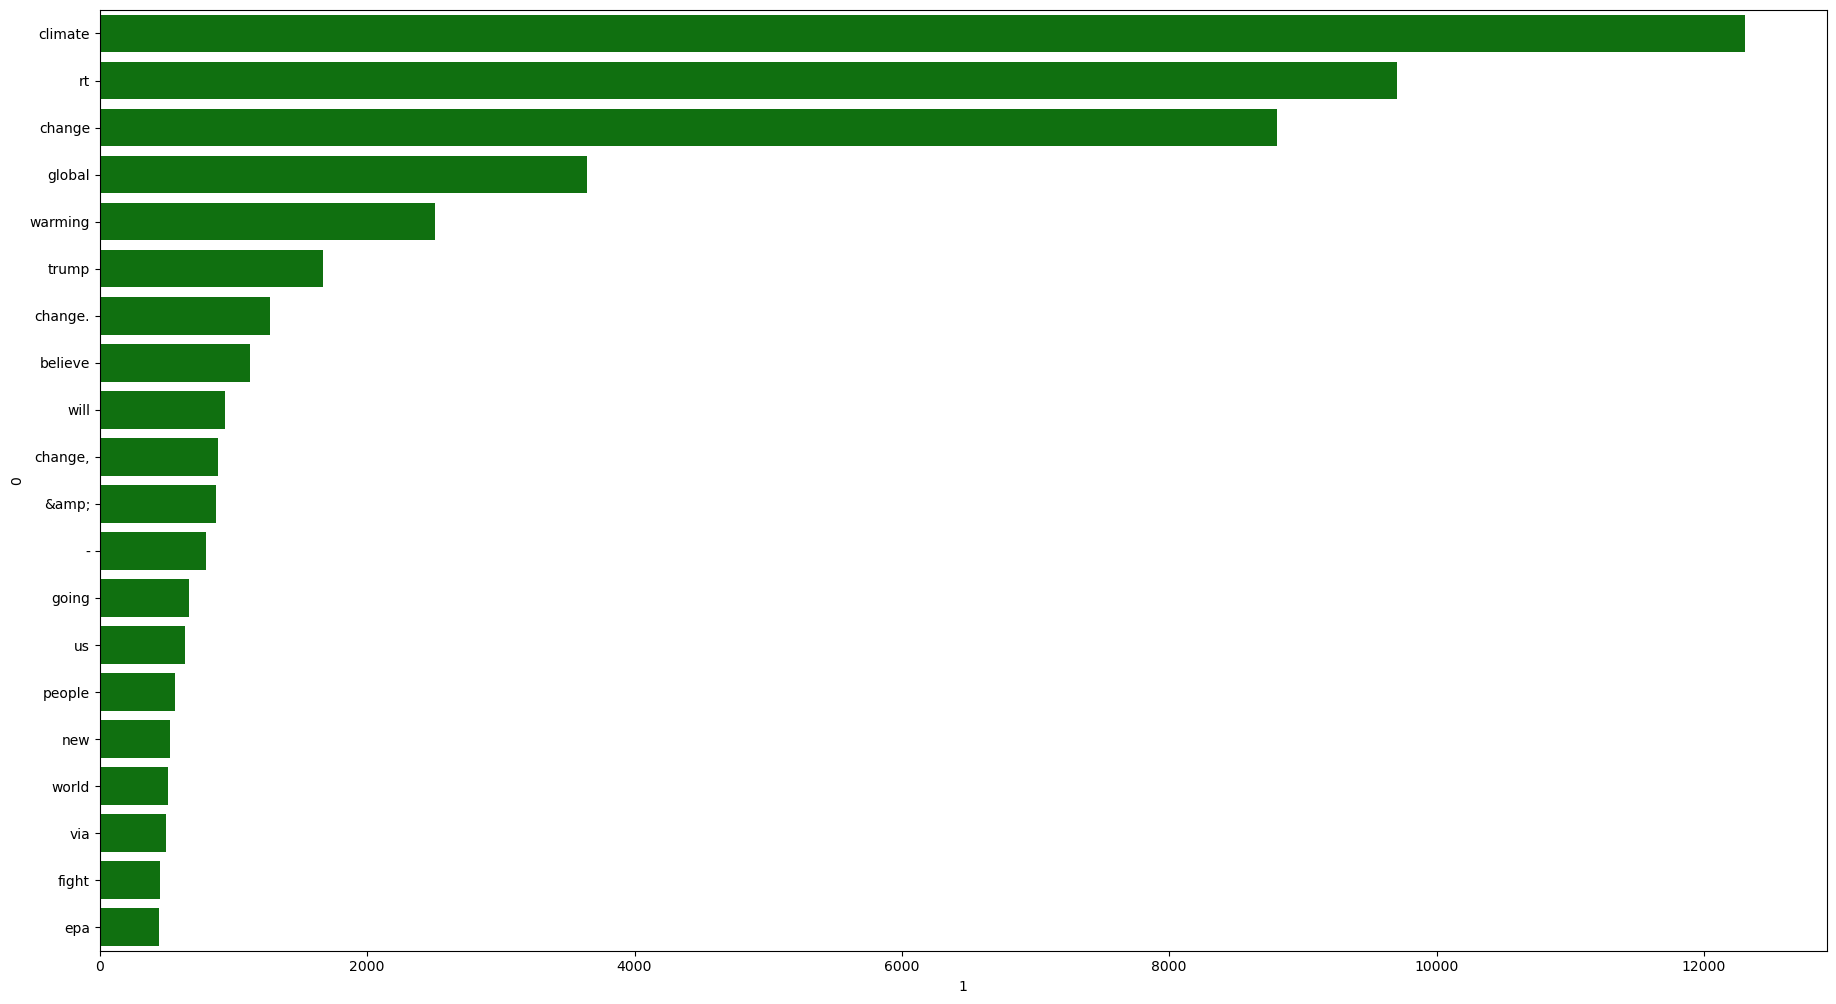

In [ ]:
fig, axes = plt.subplots(figsize=(18, 20//2), dpi=100)
plt.tight_layout()

sns.barplot(y=bow[0], x=bow[1], color='green')

for i in range(0):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

plt.show()

### BI-grams

##### Creating BI-Grams

In [41]:
bigrams = defaultdict(int)
for tweet in train_data['message']:
    for word in create_ngrams(tweet, 2):
       bigrams[word] += 1
        
bigrams_df = pd.DataFrame(sorted(bigrams.items(), key=lambda x: x[1])[::-1])

bigram_data = bigrams_df[:20]

NameError: name 'STOPWORDS' is not defined

##### Visualizing BI-Grams

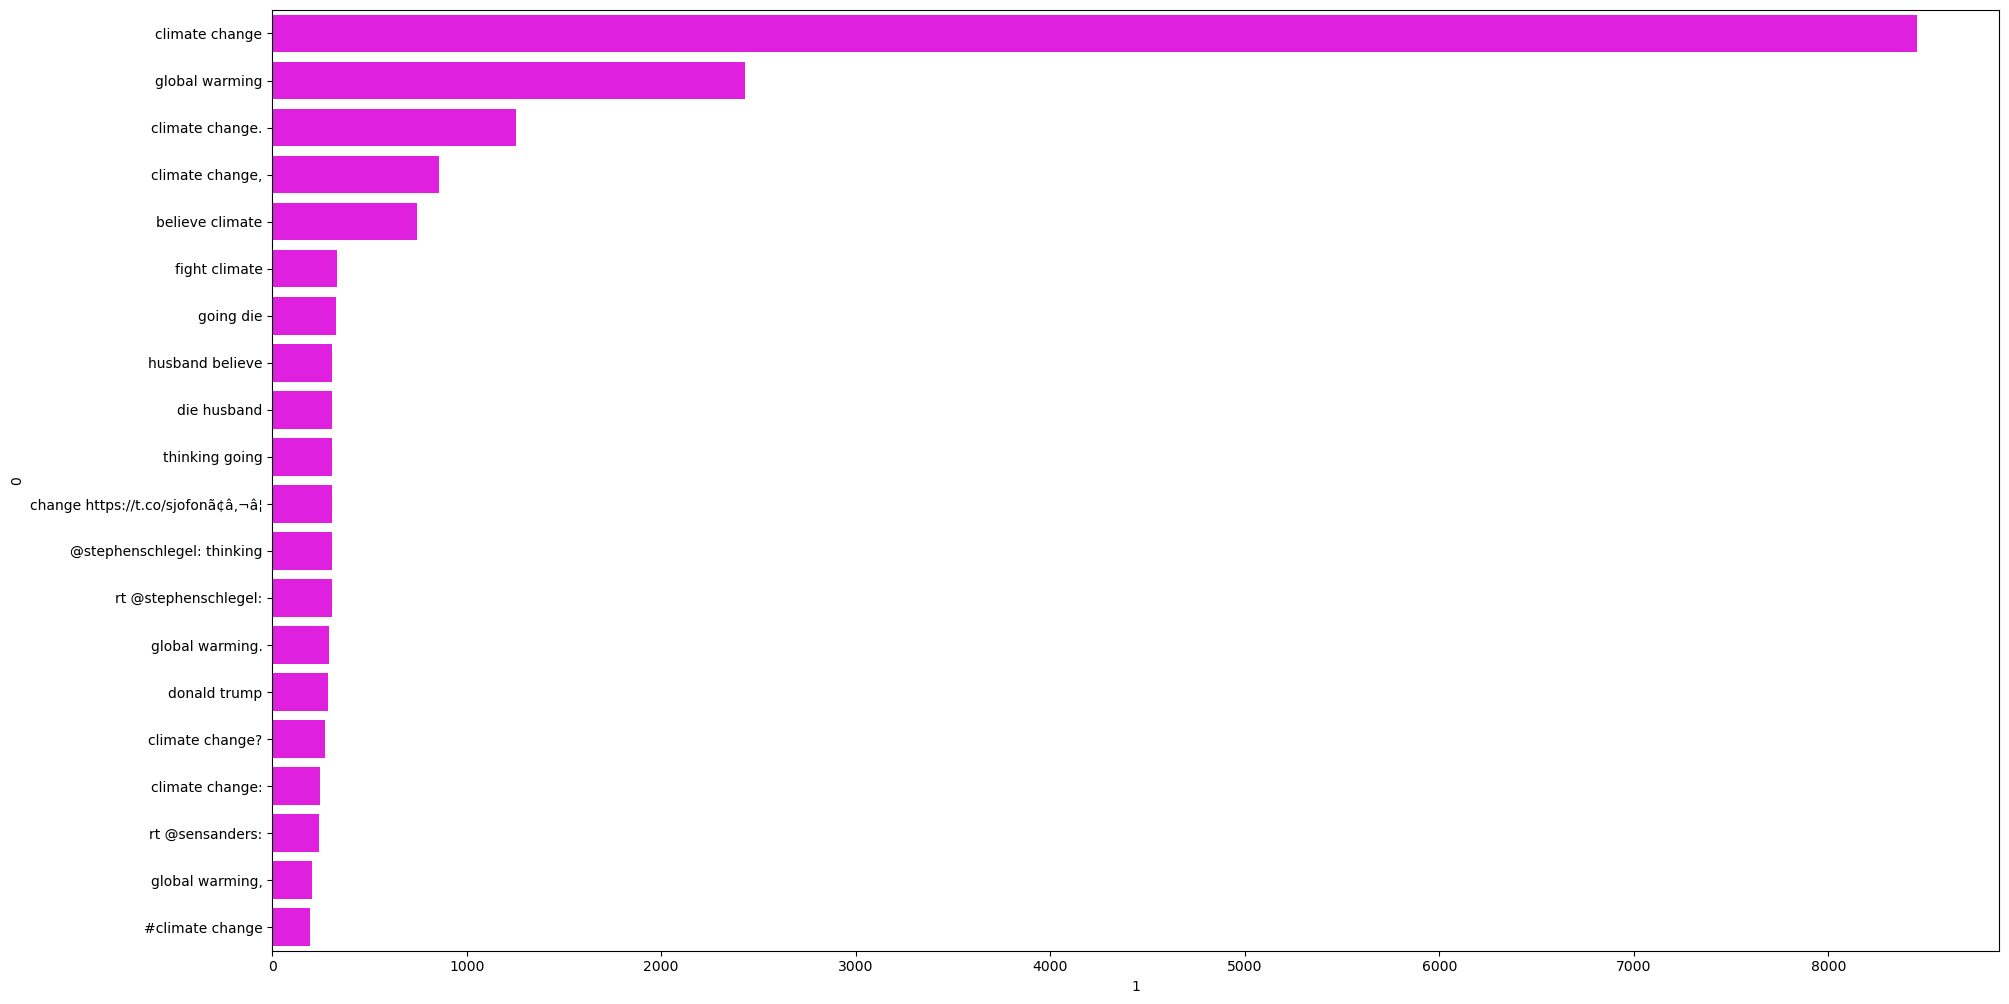

In [ ]:
fig, axes = plt.subplots(figsize=(18, 20//2), dpi=100)
plt.tight_layout()

sns.barplot(y=bigram_data[0], x=bigram_data[1],  color='magenta')


for i in range(0):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

plt.show()

### Word Cloud for the train data

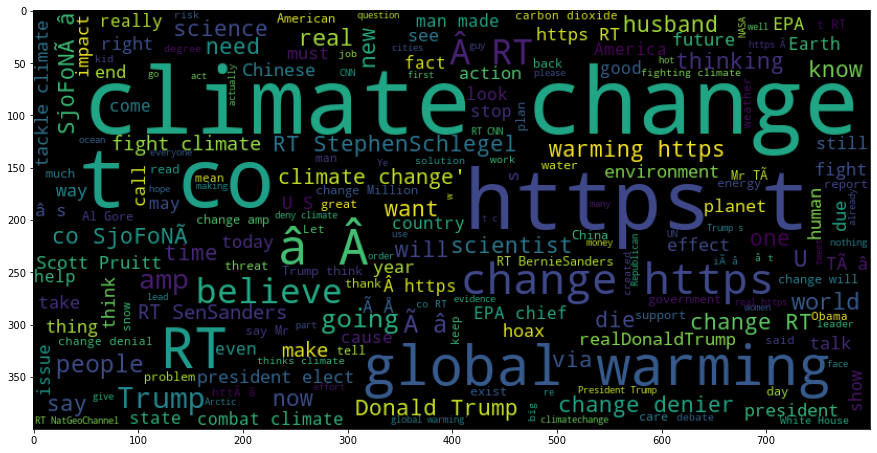

In [ ]:
from wordcloud import WordCloud 
allwords = ' '.join( [tweets for tweets in train_data['message']])
wordCloud = WordCloud(width=800, height=400,random_state=42).generate(allwords)
plt.figure( figsize=(15,10) )
plt.imshow(wordCloud)

### putting in the category column for better analysis

In [42]:
#Function to lable our Sentiments
def getAnalysis(score):
    """
    Classifies tweets as News, Pro, Neutral, or Anti based on their sentiment number
    
    Parameters:
    score: an integer (int64)
    
    returns:
    The word corresponding to the integer
    """
    if score == 2:
        return 'News'
    elif score == 1:
        return 'Pro'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Anti'
train_data['Analysis'] = train_data['sentiment'].apply(getAnalysis) # Adding an Analysis column to the df dataframe


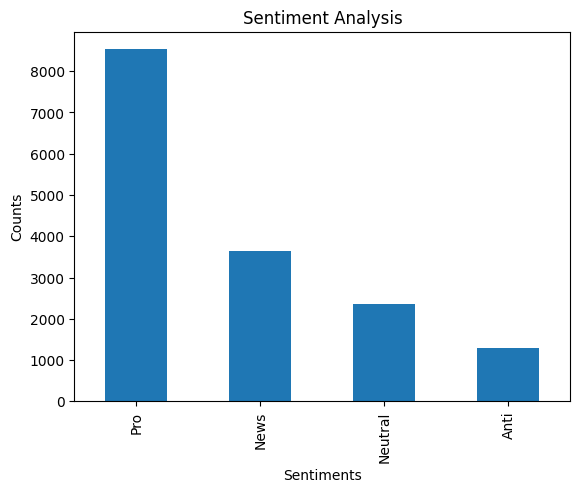

In [43]:
#Show the counts
train_data['Analysis'].value_counts()

#plot and visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiments')
plt.ylabel('Counts')
train_data['Analysis'].value_counts().plot(kind='bar')
plt.show()

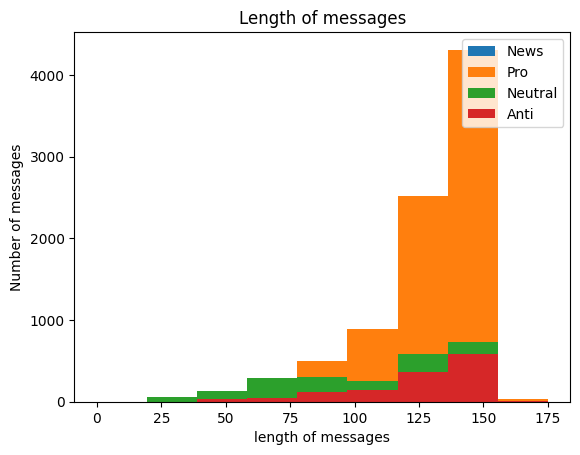

In [44]:
# Extracting the length of each entry under the message column in the train data
train_data['msg_len'] = train_data['message'].apply(lambda x: len(x)) 
from matplotlib import pyplot
%matplotlib inline
bins = np.linspace(0, 175,10)
pyplot.hist(train_data[train_data['Analysis'] == 'News']['msg_len'],bins, label = 'News')
pyplot.hist(train_data[train_data['Analysis'] == 'Pro']['msg_len'],bins, label = 'Pro')
pyplot.hist(train_data[train_data['Analysis'] == 'Neutral']['msg_len'],bins,label = 'Neutral')
pyplot.hist(train_data[train_data['Analysis'] == 'Anti']['msg_len'],bins, label = 'Anti')
pyplot.title('Length of messages')
pyplot.legend(loc='upper right')
pyplot.xlabel('length of messages')
pyplot.ylabel('Number of messages')
pyplot.show()

## 6. Modelling
[Back to Table of Contents](#Table-of-Contents)

In [75]:
#splitting data into features and label
X = pd.read_csv("train.csv", index_col = "tweetid")["message"]
y = pd.read_csv("train.csv", index_col = "tweetid")["sentiment"]

In [76]:
#feature engineering/extraction
from sklearn.feature_extraction.text import TfidfVectorizer
tfid_vectorizer = TfidfVectorizer()
X = tfid_vectorizer.fit_transform(X)

In [77]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
#model selection and initialization
names = ['Logistic Regression', 'Nearest Neighbors',
         'Linear SVM', 'RBF SVM',
         'Decision Tree', 'Random Forest',  'AdaBoost']

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier()
]

In [79]:
#making predictions
import warnings
warnings.filterwarnings("ignore")

results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)

    print ('making predictings...')
    y_pred = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    print ('calculating scores...')
    accuracy  = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, average='macro')
    recall    = recall_score(y_train, y_pred, average='macro')

    f1        = f1_score(y_train, y_pred, average='macro')
    f1_test   = f1_score(y_test, y_pred_test, average='macro')

    # Save the results to dictionaries
    models[name] = clf
    confusion[name] = confusion_matrix(y_train, y_pred)
    class_report[name] = classification_report(y_train, y_pred)

    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])


results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)


Fitting Logistic Regression model...
making predictings...
calculating scores...
Fitting Nearest Neighbors model...
making predictings...
calculating scores...
Fitting Linear SVM model...
making predictings...
calculating scores...
Fitting RBF SVM model...
making predictings...
calculating scores...
Fitting Decision Tree model...
making predictings...
calculating scores...
Fitting Random Forest model...
making predictings...
calculating scores...
Fitting AdaBoost model...
making predictings...
calculating scores...


### Model Performance

In [80]:
#getting the model performance
results.sort_values('F1 Train', ascending=False)

Accuracy  Precision    Recall  F1 Train   F1 Test  \
Classifier                                                               
RBF SVM              0.997313   0.998177  0.995396  0.996779  0.493685   
Logistic Regression  0.864085   0.906353  0.745004  0.796442  0.613175   
Nearest Neighbors    0.813591   0.756988  0.767975  0.760930  0.570438   
AdaBoost             0.648044   0.611720  0.498738  0.522683  0.512082   
Decision Tree        0.609719   0.686735  0.399980  0.418763  0.400835   
Linear SVM           0.536231   0.383957  0.250937  0.176310  0.179875   
Random Forest        0.535362   0.133840  0.250000  0.174344  0.178390   

                     Train Time  
Classifier                       
RBF SVM               52.238615  
Logistic Regression    1.364249  
Nearest Neighbors      0.001092  
AdaBoost              27.939325  
Decision Tree          0.764681  
Linear SVM            25.696350  
Random Forest          0.030708

<AxesSubplot: xlabel='Classifier'>

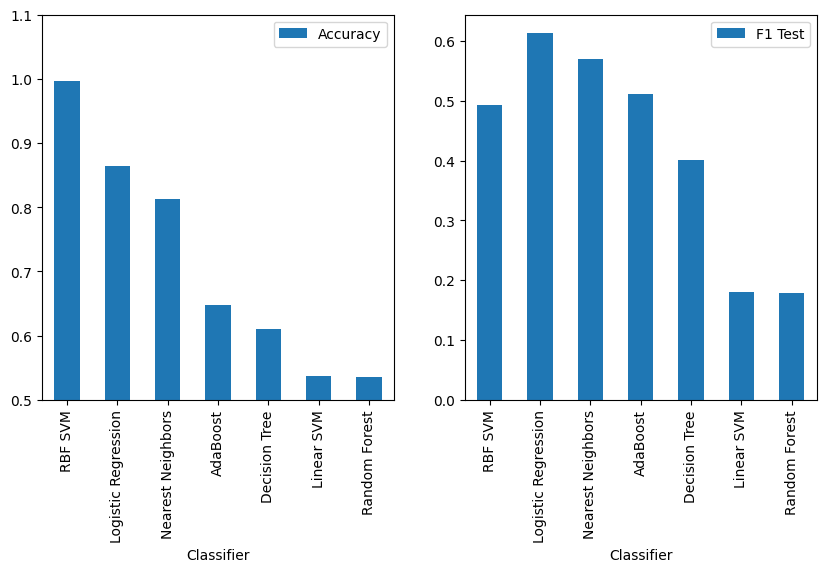

In [81]:
#visualizing the model performances for comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('Accuracy', ascending=False, inplace=True)
results.plot(y=['Accuracy'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.50,1.1])
results.plot(y='F1 Test', kind='bar', ax=ax[1])


In [82]:
#choosing the logistic Regression
model_lg = models['Logistic Regression']
X_test =  pd.read_csv("test_with_no_labels.csv")["message"]
v_test = tfid_vectorizer.transform(X_test)

# setup dataframe for results
test_data = []
test_data = pd.read_csv("test_with_no_labels.csv")

# Making predictions on the test data and adding a sentiment column 
test_data['sentiment'] = model_lg.predict(v_test)

#creating an output csv for submission
test_data[['tweetid','sentiment']].to_csv('logistic.csv', index=False)

In [86]:
# save model to pickle 

#splitting data into features and label
X = pd.read_csv("train.csv", index_col = "tweetid")["message"]
y = pd.read_csv("train.csv", index_col = "tweetid")["sentiment"]

# feature engineering/extraction
# pkl not working with TfidfVectorizer only CountVectorizer
tfid_vectorizer2 = CountVectorizer()
X = tfid_vectorizer2.fit_transform(X)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create logistic regression model for pkl file and streamlit app
models = {}
names = ['Logistic Regression']
classifiers = [LogisticRegression()]
for name, clf in zip(names, classifiers):
    # model for pkl file
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    models[name] = clf

model_lg2 = models['Logistic Regression']

model_save_path = "mlr_model2.pkl"
with open(model_save_path, 'wb') as file:
    pickle.dump(model_lg2, file)

vectorizer_save_path = "mlr_vectorizer2.pkl"
with open(vectorizer_save_path, 'wb') as file:
    pickle.dump(tfid_vectorizer2, file)


#### Stopping the comet experiment

In [ ]:
experiment.end()

## 7. Conclusion
[Back to Table of Contents](#Table-of-Contents)

So what does all this technical information mean for your business? Sustainability is no longer a buzz word. It is a global philosophy on how people and companies can improve the future by taking climate change and other environmental concerns seriously. 

Social media can make and break reputations. Using the models presented here and the app page to monitor how the world views social media in relation to your company enables you to monitor the online opinion of your customers and future customers.
